In [0]:
!pip install scorecardpy

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.1.1-cp36-none-any.whl size=58169 sha256=17db6118c4dd6833f1c35916085ba168653ba0542fd994c78278210b5af13ad8
  Stored in directory: /root/.cache/pip/wheels/8f/4c/98/567ff70984acd88ffae211d8fc209e34b98fb43ff27f09fdd3
Successfully built scorecardpy


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Business Understanding

In [0]:
import pandas as pd
import scorecardpy as sc
import numpy as np

In [0]:
df = pd.read_csv('/content/drive/My Drive/train (2).csv')

# Data Understanding

In [0]:
df.Product_Info_2.unique()

array(['D3', 'A1', 'E1', 'D4', 'D2', 'A8', 'A2', 'D1', 'A7', 'A6', 'A3',
       'A5', 'C4', 'C1', 'B2', 'C3', 'C2', 'A4', 'B1'], dtype=object)

#Data Preparation

In [0]:
df.Response = pd.Series(np.where(df.Response == 1, 1, 0))

In [0]:
df.Response.value_counts()

0    44181
1    15200
Name: Response, dtype: int64

In [0]:
medical_keyword_cols=[col for col in df.columns if str(col).startswith("Medical_Keyword")]
medical_cols=[col for col in df.columns if str(col).startswith("Medical_History")]
product_info_cols =[col for col in df.columns if str(col).startswith("Product_Info")]
employment_info_cols=[col for col in df.columns if str(col).startswith("Employment_Info")]
insured_info_cols =[col for col in df.columns if str(col).startswith("InsuredInfo")]
insured_history_cols=[col for col in df.columns if str(col).startswith("Insurance_History")]
family_history_cols =[col for col in df.columns if str(col).startswith("Family_Hist")]

df['Total_Medical_Keyword']=df[medical_keyword_cols].sum(axis=1)
df['Total_Medical_History']=df[medical_cols].sum(axis=1)
df['Total_Product_Info']=df[product_info_cols].sum(axis=1)
df['Total_Employment_Info']=df[employment_info_cols].sum(axis=1)
df['Total_InsuredInfo']=df[insured_info_cols].sum(axis=1)
df['Total_Insurance_History']=df[insured_history_cols].sum(axis=1)
df['Total_Family_Hist']=df[family_history_cols].sum(axis=1)

In [0]:
kolom_terpilih = ["Ins_Age", "Ht", "Wt", "BMI", 'Total_Medical_Keyword', 'Total_Medical_History', 'Total_Product_Info', 'Total_Employment_Info', 'Total_InsuredInfo', 'Total_Insurance_History', 'Total_Family_Hist', "Response"]
df = df[kolom_terpilih]

In [0]:
df.shape

(59381, 12)

In [0]:
# Traditional Credit Scoring Using Logistic Regression

# data prepare ------
# load germancredit data
dat = df#$sc.germancredit()

# filter variable via missing rate, iv, identical value rate
dt_s = sc.var_filter(dat, y="Response")

# breaking dt into train and test
train, test = sc.split_df(dt_s, 'Response').values()

# woe binning ------
bins = sc.woebin(dt_s, y="Response")
# sc.woebin_plot(bins)

# binning adjustment
# # adjust breaks interactively
# breaks_adj = sc.woebin_adj(dt_s, "creditability", bins) 
# # or specify breaks manually
# breaks_adj = {
#     'age.in.years': [26, 35, 40],
#     'other.debtors.or.guarantors': ["none", "co-applicant%,%guarantor"]
# }
# bins_adj = sc.woebin(dt_s, y="creditability", breaks_list=breaks_adj)

# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

y_train = train_woe.loc[:,'Response']
X_train = train_woe.loc[:,train_woe.columns != 'Response']
y_test = test_woe.loc[:,'Response']
X_test = test_woe.loc[:,train_woe.columns != 'Response']

[INFO] filtering variables ...
Variable filtering on 59381 rows and 12 columns in 00:00:44 
0 variables are removed
[INFO] creating woe binning ...
Binning on 59381 rows and 12 columns in 00:00:12
[INFO] converting into woe values ...
[INFO] converting into woe values ...


#Modeling

In [0]:
# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=3, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
lr.coef_
lr.intercept_

array([-1.06659572])

#Evaluation

/usr/local/lib/python3.6/dist-packages/scorecardpy/perf.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  ], ignore_index=True)


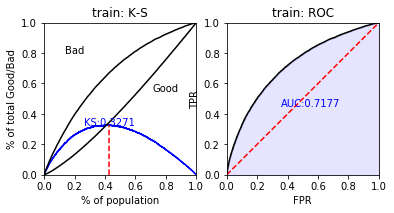

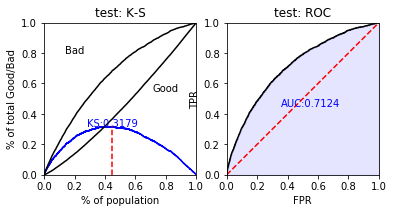

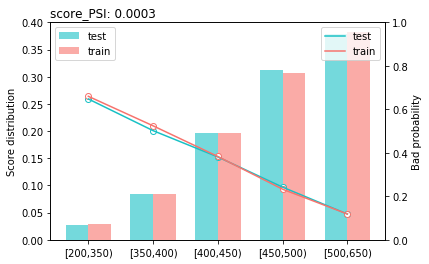

{'pic': {'score': <Figure size 432x288 with 2 Axes>},
 'psi':   variable       PSI
 0    score  0.000313}

In [0]:
y_pred=lr.predict(X_test)
# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# score ------
card = sc.scorecard(bins, lr, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

#Deployment

In [0]:
a = pd.DataFrame()
for i in card:
  b = pd.DataFrame(card[i])
  a = a.append(b)
a

,variable,bin,points
0,basepoints,NaN,465.0
0,Wt,"[-inf,0.2)",21.0
1,Wt,"[0.2,0.30000000000000004)",9.0
2,Wt,"[0.30000000000000004,0.4)",-4.0
3,Wt,"[0.4,inf)",-38.0
4,Total_Employment_Info,"[-inf,7.0)",-25.0
5,Total_Employment_Info,"[7.0,8.0)",-6.0
6,Total_Employment_Info,"[8.0,inf)",4.0
7,Total_Product_Info,"[-inf,32.90000000000002)",10.0
8,Total_Product_Info,"[32.90000000000002,33.10000000000002)",-33.0


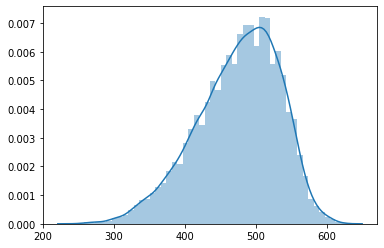

In [0]:
import seaborn as sns
sns.distplot(train_score)

In [0]:
train_score.quantile([0.25,0.5,0.75])

,score
0.25,437.0
0.50,482.0
0.75,519.0


In [0]:
train_score.mean()

score    474.908942
dtype: float64

In [0]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7540136970921747
Precision: 0.5584756898817346
Recall: 0.18640350877192982
